<a href="https://colab.research.google.com/github/yelim421/SolarPower/blob/main/G_era5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Solar_Power

/content/drive/MyDrive/Solar_Power


In [ ]:
import numpy as np
import pandas as pd
import itertools
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
import itertools
import tensorflow as tf
from keras.models import load_model

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
with open('temp.csv', 'r') as f:
    data = pd.read_csv(f)

In [ ]:
no_time_data = data.drop(columns=['DateTime'])
values = no_time_data.values.astype('float32')
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

new_data = pd.DataFrame(scaled, columns=no_time_data.columns, index=no_time_data.index)
new_data

,Month,Day,Hour,Temperature(C),Precipitation(mm),Humidity(%),VaporPressure(hPa),DewPointTemperature(C),Sunshine(hr),SolarRadiation(MJ/m2),Snowfall(cm),TotalCloudCoverage(1/10),Visibility(10m),d2m,t2m,aerosol,power
0,-0.636364,0.2,-0.857143,-0.275424,-1.0,0.977011,-0.615572,-0.017021,-1.0,-0.994624,-1.0,0.4,-0.881882,0.097522,0.048522,-0.795501,-1.000000
1,-0.636364,0.2,-0.714286,-0.241525,-1.0,0.908046,-0.605839,-0.004255,-1.0,-0.870968,-1.0,0.4,-0.881882,0.099786,0.029932,-0.783231,-0.869666
2,-0.636364,0.2,-0.571429,-0.161017,-1.0,0.770115,-0.571776,0.038298,-0.4,-0.607527,-1.0,-0.4,-0.881882,0.108781,0.018901,-0.799591,-0.532971
3,-0.636364,0.2,-0.428571,-0.076271,-1.0,0.517241,-0.571776,0.038298,1.0,-0.279570,-1.0,-1.0,-0.841842,0.150750,-0.014438,-0.811861,-0.117145
4,-0.636364,0.2,-0.285714,0.000000,-1.0,0.402299,-0.547445,0.072340,1.0,-0.021505,-1.0,-1.0,-0.841842,0.155836,-0.018744,-0.840491,0.194725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43670,1.000000,1.0,0.142857,-0.330508,-1.0,-0.126437,-0.858881,-0.459575,0.8,-0.021505,-1.0,-0.6,0.612012,-0.444815,-0.420150,-0.975460,0.495733
43671,1.000000,1.0,0.285714,-0.330508,-1.0,-0.126437,-0.858881,-0.459575,1.0,-0.112903,-1.0,-1.0,0.658058,-0.410262,-0.417576,-0.965235,0.314197
43672,1.000000,1.0,0.428571,-0.338983,-1.0,-0.126437,-0.863747,-0.468085,1.0,-0.381720,-1.0,-1.0,0.689289,-0.372879,-0.398348,-0.961145,-0.095423
43673,1.000000,1.0,0.571429,-0.364407,-1.0,-0.080460,-0.863747,-0.468085,1.0,-0.709677,-1.0,-1.0,0.715716,-0.343220,-0.412831,-0.979550,-0.621412


In [ ]:

# Selecting features and target
X = new_data.drop(columns=['power'])
y = new_data['power']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying MinMaxScaler
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Scaling the features
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Scaling the target variable
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

print(X_train_scaled.shape, y_train_scaled.shape, X_test_scaled.shape, y_test_scaled.shape)

# Define hyperparameter grid
config = [[True, False], [16, 32, 64, 128], [8, 16, 32]]
additional_layer, n_neurons, n_batch_size = config
possible_combinations = list(itertools.product(additional_layer, n_neurons, n_batch_size))

# Initialize lists to store results
validation_loss = np.zeros((5, len(possible_combinations)))

print('Possible combinations: ', len(possible_combinations))
print('\n')

(34940, 16) (34940,) (8735, 16) (8735,)
Possible combinations:  24




In [ ]:
config = [[True, False], [16, 32, 64, 128], [8, 16, 32]]  #, 32, 16// , 8
additional_layer, n_neurons, n_batch_size = config
possible_combinations = list(itertools.product(additional_layer, n_neurons, n_batch_size))

In [ ]:
# 학습 데이터, 테스트 데이터 분리
values = new_data#.values
n_test_hours = int(4000)
train = values.iloc[:-n_test_hours, :]
test = values.iloc[-n_test_hours:, :]

train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]

# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(39675, 16) (39675,) (4000, 16) (4000,)


In [ ]:
dropout = 0.2
validation_loss = np.zeros((5,len(possible_combinations)))
fold_var = 1
kfold = KFold(n_splits = 5, shuffle = True)

print('Possible combinations: ', len(possible_combinations))
print('\n')
losses = np.empty(len(possible_combinations))

with tf.device('/device:GPU:0'):

    for i in range(0, len(possible_combinations)):
        print('--------------------------------------------------------------------')
        print(f'Combination #{i+1}: {possible_combinations[i]}\n')


        additional_layer, n_neurons, n_batch_size = possible_combinations[i]

        val_loss = []; train_loss = []
        for j, (train_index, val_index) in enumerate(kfold.split(train_X)):

            val_train_X = train_X.iloc[train_index,:]
            val_X =  train_X.iloc[val_index,:]
            val_train_y = train_y.iloc[train_index]
            val_y =  train_y.iloc[val_index]

            val_train_X2 = val_train_X.values.reshape((val_train_X.shape[0], 1,val_train_X.shape[1]))
            val_train_y2 = val_train_y.values.reshape((val_train_y.shape[0]))
            val_X2 = val_X.values.reshape(( val_X.shape[0], 1,val_X.shape[1]))
            val_y2 = val_y.values.reshape((val_y.shape[0]))

            es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
            #mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=0, save_best_only=True)

            model = Sequential()
            model.add(GRU(units=n_neurons, return_sequences=True, input_shape=(1,train_X.shape[1])))
            model.add(Dropout(dropout))
            if additional_layer:
                model.add(GRU(units=n_neurons, return_sequences=True))
                model.add(Dropout(dropout))
            model.add(GRU(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))
            model.add(GRU(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))
            model.add(GRU(units=n_neurons, return_sequences=False))
            model.add(Dropout(dropout))
            model.add(Dense(units=1, activation='tanh'))

            model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
            model.fit(val_train_X2, val_train_y2, epochs=100, verbose=0, batch_size=n_batch_size, callbacks=[es], shuffle = False) #

            train_accuracy = model.evaluate(val_train_X2, val_train_y2, verbose=0)
            val_accuracy = model.evaluate(val_X2, val_y2, verbose=0)

            print(f'{j+1}-FOLD ====> train loss: {train_accuracy[0]}     val loss: {val_accuracy[0]}')
            train_loss.append(train_accuracy[0])
            val_loss.append(val_accuracy[0])

        print(f'train loss: {sum(train_loss)/len(train_loss)}     val loss: {sum(val_loss)/len(val_loss)}')
        losses[i] = sum(val_loss)/len(val_loss)


Possible combinations:  24


--------------------------------------------------------------------
Combination #1: (True, 16, 8)

1-FOLD ====> train loss: 0.018130384385585785     val loss: 0.018349086865782738
2-FOLD ====> train loss: 0.01786627434194088     val loss: 0.01692664436995983
3-FOLD ====> train loss: 0.01728048548102379     val loss: 0.018069127574563026
4-FOLD ====> train loss: 0.017767837271094322     val loss: 0.01886269636452198
5-FOLD ====> train loss: 0.017492493614554405     val loss: 0.01828443445265293
train loss: 0.017707495018839836     val loss: 0.018098397925496102
--------------------------------------------------------------------
Combination #2: (True, 16, 16)

1-FOLD ====> train loss: 0.017729945480823517     val loss: 0.01864132098853588
2-FOLD ====> train loss: 0.017625993117690086     val loss: 0.017454614862799644
3-FOLD ====> train loss: 0.017002778127789497     val loss: 0.017646847292780876
4-FOLD ====> train loss: 0.018132196739315987     val loss: 

In [ ]:
# @title


In [ ]:

# Simplified model training
k = 5
kfold = KFold(n_splits=k, shuffle=True)
losses = np.empty(len(possible_combinations))

for i, (add_layer, neurons, batch_size) in enumerate(possible_combinations):
    if not add_layer:  # Only train the model for configurations without the additional layer
        print('--------------------------------------------------------------------')
        print(f'{i+1}th combination:')
        print('Additional Layer:', add_layer)
        print('Neurons:', neurons)
        print('Batch Size:', batch_size)
        val_loss = []
        train_loss = []

        for train_index, val_index in kfold.split(X_train_scaled):
            fold_train_X = X_train_scaled[train_index]
            fold_val_X = X_train_scaled[val_index]
            fold_train_y = y_train_scaled[train_index]
            fold_val_y = y_train_scaled[val_index]

            fold_train_X2 = fold_train_X.reshape((fold_train_X.shape[0], 1, fold_train_X.shape[1]))
            fold_val_X2 = fold_val_X.reshape((fold_val_X.shape[0], 1, fold_val_X.shape[1]))

            es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

            model = Sequential()
            model.add(GRU(units=neurons, return_sequences=False, input_shape=(1, X_train.shape[1])))
            model.add(Dropout(0.2))
            model.add(Dense(units=1, activation='tanh'))
            model.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError()])

            model.fit(fold_train_X2, fold_train_y, epochs=100, verbose=0, batch_size=batch_size, callbacks=[es], shuffle=False)

            train_accuracy = model.evaluate(fold_train_X2, fold_train_y, verbose=0)[0]
            val_accuracy = model.evaluate(fold_val_X2, fold_val_y, verbose=0)[0]

            train_loss.append(train_accuracy)
            val_loss.append(val_accuracy)

        mean_train_loss = np.mean(train_loss)
        mean_val_loss = np.mean(val_loss)
        print(f'train loss: {mean_train_loss}     val loss: {mean_val_loss}')
        losses[i] = mean_val_loss

    # Clear the session to free up memory
    tf.keras.backend.clear_session()

# Identify the best hyperparameters based on validation loss
best_index = np.argmin(losses)
print(f"Best hyperparameters: {possible_combinations[best_index]} with validation loss: {losses[best_index]}")

--------------------------------------------------------------------
13th combination:
Additional Layer: False
Neurons: 16
Batch Size: 8


KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def apply_standard_scaling(train_file_path, test_file_path):
    # Load the datasets
    train_data = pd.read_csv(train_file_path)
    test_data = pd.read_csv(test_file_path)

    # Drop the 'DateTime' column
    train_data_no_time = train_data.drop(columns=['DateTime'])
    test_data_no_time = test_data.drop(columns=['DateTime'])

    # Initialize the scaler
    scaler = StandardScaler()

    # Fit the scaler to the training data and transform
    train_scaled_array = scaler.fit_transform(train_data_no_time.values.astype('float32'))

    # Transform the test data
    test_scaled_array = scaler.transform(test_data_no_time.values.astype('float32'))


    # Convert the scaled arrays back to DataFrames
    train_scaled_df = pd.DataFrame(train_scaled_array, columns=train_data_no_time.columns)
    test_scaled_df = pd.DataFrame(test_scaled_array, columns=test_data_no_time.columns)
    print('------done apply_standard_scaling---------------')
    return train_scaled_df, test_scaled_df

def get_data_splits(train_scaled, test_scaled):
    train_X = train_scaled.drop(columns=['power'])
    test_X = test_scaled.drop(columns=['power'])
    train_y = train_scaled['power']
    test_y = test_scaled['power']
    #X_train.shape, y_train.shape, X_test.shape, y_test.shape
    #((39205, 16), (39205,), (4470, 16), (4470,))
    print('------done get_data_splits---------------')
    return train_X, train_y, test_X, test_y


def get_possible_combinations():
    config = [[True, False], [16, 32, 64, 128], [8, 16, 32]]
    print('------done get_possible combinations---------------')
    return list(itertools.product(*config))

def create_and_train_model(train_X, train_y, test_X, test_y, n_neurons, n_batch_size, dropout, additional_layer):
    train_X2 = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
    train_y2 = train_y.values.reshape((train_y.shape[0]))

    train_X3, valid_X, train_y3, valid_y = train_test_split(train_X2, train_y2, test_size = 0.2, shuffle = False)

    test_X2 = test_X.values.reshape((test_X.shape[0], 1,test_X.shape[1]))
    test_y2 = test_y.values#.reshape((test_y.shape[0]))

    model = Sequential()
    model.add(GRU(units=n_neurons, return_sequences=True, input_shape=(1, train_X.shape[1])))
    model.add(Dropout(dropout))
    if additional_layer:
        model.add(GRU(units=n_neurons, return_sequences=True))
        model.add(Dropout(dropout))
    model.add(GRU(units=n_neurons, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(units=n_neurons, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(units=n_neurons, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='tanh'))

    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
    mc = ModelCheckpoint(f_name, monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    rl = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00000001)

    model.fit(train_X3, train_y3, validation_data = (valid_X, valid_y), epochs=100, verbose=1, batch_size=n_batch_size, callbacks=[es, mc, rl], shuffle=False)
    print('------done create_and_train_model---------------')
    return model

def evaluate_hyperparameters(train_X, train_y):
    possible_combinations = get_possible_combinations()
    kfold = KFold(n_splits=5, shuffle=True)
    losses = np.empty(len(possible_combinations))

    for i, (additional_layer, n_neurons, n_batch_size) in enumerate(possible_combinations):
        print('--------------------------------------------------------------------')
        print(f'Combination #{i+1}: {additional_layer, n_neurons, n_batch_size}\n')

        val_loss = []
        for j, (train_index, val_index) in enumerate(kfold.split(train_X)):
            val_train_X = train_X.iloc[train_index, :]
            val_train_y = train_y.iloc[train_index]

            model = create_and_train_model(val_train_X, val_train_y, n_neurons, n_batch_size, 0.2, additional_layer)

            val_X = train_X.iloc[val_index, :].values.reshape((-1, 1, train_X.shape[1]))
            val_y = train_y.iloc[val_index].values

            val_accuracy = model.evaluate(val_X, val_y, verbose=0)
            val_loss.append(val_accuracy[1])

            print(f'{j+1}-FOLD ====> val RMSE: {val_accuracy[1]}')

        mean_val_loss = np.mean(val_loss)
        print(f'Mean validation RMSE: {mean_val_loss}')
        losses[i] = mean_val_loss

    best_index = np.argmin(losses)
    print(f"Best hyperparameters: {possible_combinations[best_index]} with validation RMSE: {losses[best_index]}")

    return possible_combinations[best_index], losses[best_index]

# Applying the functions

def main():
    train_scaled_df, test_scaled_df = apply_standard_scaling('train_data_datetime.csv', 'test_data_datetime.csv')
    train_X, train_y, test_X, test_y = get_data_splits(train_scaled_df, test_scaled_df)
    model = create_and_train_model(train_X, train_y, test_X, test_y, n_neurons, n_batch_size, dropout, additional_layer)
    train_X2 = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
    train_y2 = train_y.values.reshape((train_y.shape[0]))
    test_X2 = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))
    test_y2 = test_y.values
    #best_hyperparameters, best_loss = evaluate_hyperparameters(train_X, train_y)
    train_accuracy = model.evaluate(train_X2, train_y2, verbose=1)
    test_accuracy = model.evaluate(test_X2, test_y2, verbose=1)
    return train_accuracy, test_accuracy

# If this script is being run as the main module, execute the main function
if __name__ == "__main__":

    additional_layer = True
    n_neurons = 64
    n_batch_size = 32
    combination_no = 9
    dropout=0.2

    f_name = f'best_model{combination_no}.h5'

    best_hyperparameters, best_loss = main()
    print(f"Best hyperparameters: {best_hyperparameters}")
    print(f"Best validation RMSE: {best_loss}")

------done apply_standard_scaling---------------
------done get_data_splits---------------
Epoch 1/100
981/981 [==============================] - 21s 9ms/step - loss: 0.1831 - root_mean_squared_error: 0.4279 - val_loss: 0.1277 - val_root_mean_squared_error: 0.3574 - lr: 0.0010
Epoch 2/100
981/981 [==============================] - 8s 8ms/step - loss: 0.1355 - root_mean_squared_error: 0.3681 - val_loss: 0.1312 - val_root_mean_squared_error: 0.3623 - lr: 0.0010
Epoch 3/100
981/981 [==============================] - 8s 8ms/step - loss: 0.1320 - root_mean_squared_error: 0.3633 - val_loss: 0.1305 - val_root_mean_squared_error: 0.3612 - lr: 0.0010
Epoch 4/100
981/981 [==============================] - 9s 9ms/step - loss: 0.1278 - root_mean_squared_error: 0.3576 - val_loss: 0.1270 - val_root_mean_squared_error: 0.3563 - lr: 0.0010
Epoch 5/100
981/981 [==============================] - 9s 9ms/step - loss: 0.1242 - root_mean_squared_error: 0.3524 - val_loss: 0.1186 - val_root_mean_squared_error

In [ ]:
import itertools
import tensorflow as tf
from keras.models import load_model
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error
model = load_model('best_model_linear9.h5')

train_scaled_df, test_scaled_df = apply_standard_scaling('era5_train_set.csv', 'era5_test_set.csv')
train_X, train_y, test_X, test_y = get_data_splits(train_scaled_df, test_scaled_df)
train_X2 = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
train_y2 = train_y.values.reshape((train_y.shape[0]))
test_X2 = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))
test_y2 = test_y.values

scaler = StandardScaler()
train_data = pd.read_csv('train_data_datetime.csv')
test_data = pd.read_csv('test_data_datetime.csv')

    # Drop the 'DateTime' column
train_data_no_time = train_data.drop(columns=['DateTime'])
test_data_no_time = test_data.drop(columns=['DateTime'])
train_scaled_array = scaler.fit_transform(train_data_no_time.values.astype('float32'))
test_scaled_array = scaler.transform(test_data_no_time.values.astype('float32'))



### Test Data
# 예측
yhat1 = model.predict(test_X2)
test_X3 = test_X2.reshape((test_X2.shape[0], test_X2.shape[2]))
# 스케일 되기 전 원래의 값의 형태로
inv_yhat1 = concatenate((yhat1, test_X3), axis=1)

inv_yhat1 = scaler.inverse_transform(inv_yhat1)
inv_yhat1 = inv_yhat1[:,0]
# 실제 값에 대해서도 진행
test_y3 = test_y2.reshape((len(test_y2), 1))
inv_y1 = concatenate((test_y3, test_X3), axis=1)
inv_y1 = scaler.inverse_transform(inv_y1)
inv_y1 = inv_y1[:,0]
# RMSE 계산
rmse = sqrt(mean_squared_error(inv_y1, inv_yhat1))
print('Test RMSE: %.3f' % rmse)

### Train Data
# 예측
yhat2 = model.predict(train_X2)
train_X3 = train_X2.reshape((train_X2.shape[0], train_X2.shape[2]))
# 스케일 되기 전 원래의 값의 형태로
inv_yhat2 = concatenate((yhat2, train_X3), axis=1)
inv_yhat2 = scaler.inverse_transform(inv_yhat2)
inv_yhat2 = inv_yhat2[:,0]
# 실제 값에 대해서도 진행
train_y3 = train_y2.reshape((len(train_y2), 1))
inv_y2 = concatenate((train_y3, train_X3), axis=1)
inv_y2 = scaler.inverse_transform(inv_y2)
inv_y2 = inv_y2[:,0]
# RMSE 계산
rmse = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Train RMSE: %.3f' % rmse)

TypeError: ignored

In [ ]:
# 1. 'power' 컬럼의 통계치 출력
print("Original Train 'power' stats:")
print("Max:", train_data['power'].max())
print("Min:", train_data['power'].min())
print("Mean:", train_data['power'].mean())
print("Median:", train_data['power'].median())
print("-----")
print("Original Test 'power' stats:")
print("Max:", test_data['power'].max())
print("Min:", test_data['power'].min())
print("Mean:", test_data['power'].mean())
print("Median:", test_data['power'].median())
print("===================================")

# 2. 스케일링된 'power' 값의 통계치 출력
print("Scaled Train 'power' stats:")
print("Max:", train_data['power_scaled'].max())
print("Min:", train_data['power_scaled'].min())
print("Mean:", train_data['power_scaled'].mean())
print("Median:", train_data['power_scaled'].median())
print("-----")
print("Scaled Test 'power' stats:")
print("Max:", test_data['power_scaled'].max())
print("Min:", test_data['power_scaled'].min())
print("Mean:", test_data['power_scaled'].mean())
print("Median:", test_data['power_scaled'].median())
print("===================================")

# 3. 모델로부터 얻은 예측값의 통계치 출력
print("Predicted 'power' stats:")
print("Max:", yhat1_scaled.max())
print("Min:", yhat1_scaled.min())
print("Mean:", yhat1_scaled.mean())
print("Median:", np.median(yhat1_scaled))


Original Train 'power' stats:
Max: 12384000
Min: 9600
Mean: 4039605.9660757557
Median: 3206400.0
-----
Original Test 'power' stats:
Max: 11865600
Min: 9600
Mean: 4227045.369127517
Median: 3595200.0
Scaled Train 'power' stats:
Max: 2.475142468823889
Min: -1.195394042478688
Mean: -4.349706837965159e-18
Median: -0.24714838052076848
-----
Scaled Test 'power' stats:
Max: 2.321372902019902
Min: -1.195394042478688
Mean: 0.055598911669111135
Median: -0.13182120541777828
Predicted 'power' stats:
Max: -0.33901
Min: -0.9999627
Mean: -0.53524214
Median: -0.51074326


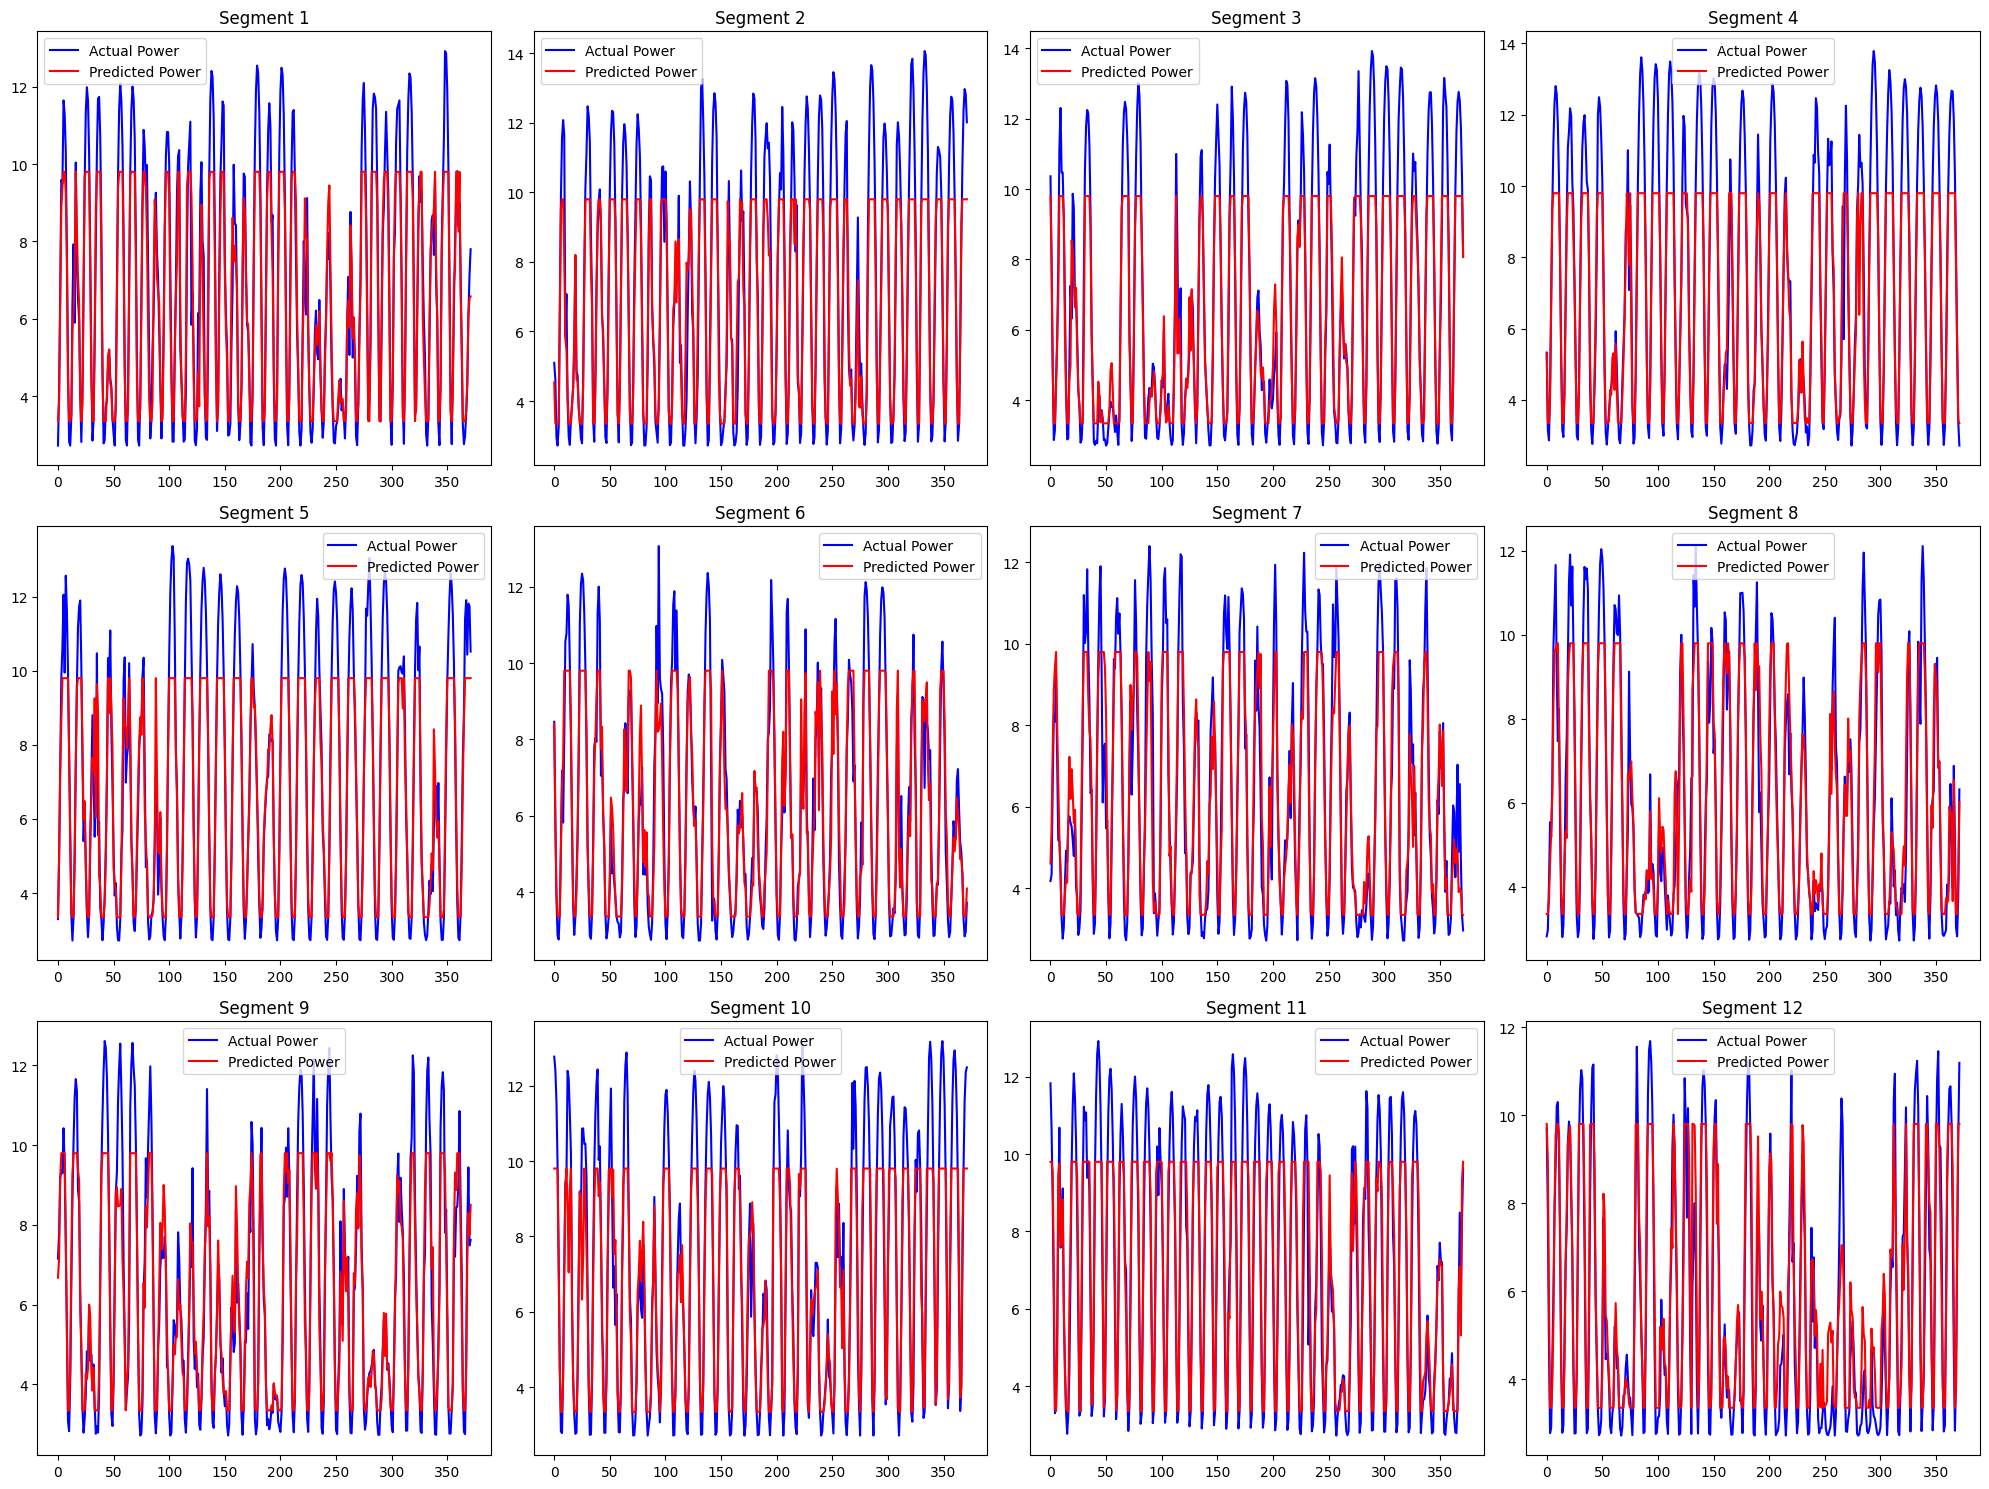

In [ ]:
# 데이터의 길이를 12로 나누어 각 구간의 길이를 계산
segment_length = len(inv_y1) // 12

plt.figure(figsize=(20, 15))

# 각 구간별로 그래프 그리기
for i in range(12):
    plt.subplot(3, 4, i+1)
    start_idx = i * segment_length
    end_idx = start_idx + segment_length
    plt.plot(inv_y1[start_idx:end_idx], label='Actual Power', color='blue')
    plt.plot(inv_yhat1[start_idx:end_idx], label='Predicted Power', color='red')
    plt.title(f'Segment {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import itertools
import numpy as np
import tensorflow as tf
from keras.models import load_model
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error
model = load_model('best_model9.h5')

train_scaled_df, test_scaled_df = apply_standard_scaling('train_data_datetime.csv', 'test_data_datetime.csv')
train_X, train_y, test_X, test_y = get_data_splits(train_scaled_df, test_scaled_df)
train_X2 = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
train_y2 = train_y.values.reshape((train_y.shape[0]))
test_X2 = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))
test_y2 = test_y.values

scaler = StandardScaler()
train_data = pd.read_csv('train_data_datetime.csv')
test_data = pd.read_csv('test_data_datetime.csv')

    # Drop the 'DateTime' column
train_data_no_time = train_data.drop(columns=['DateTime'])
test_data_no_time = test_data.drop(columns=['DateTime'])
train_scaled_array = scaler.fit_transform(train_data_no_time.values.astype('float32'))
test_scaled_array = scaler.transform(test_data_no_time.values.astype('float32'))



### Test Data
# 예측
yhat1 = model.predict(test_X2)
print(yhat1.shape)
print(yhat1[:5])
test_X3 = test_X2.reshape((test_X2.shape[0], test_X2.shape[2]))
print(test_X3.shape)
print(test_X3[:5])
# 스케일 되기 전 원래의 값의 형태로
inv_yhat1 = concatenate((yhat1, test_X3), axis=1)
print(inv_yhat1.shape)
print(inv_yhat1[:5])

inv_yhat1 = scaler.inverse_transform(inv_yhat1)
inv_yhat1 = inv_yhat1[:,0]
print(inv_yhat1.shape)
print(inv_yhat1[:5])
print(np.max(inv_yhat1))
# # 실제 값에 대해서도 진행
test_y3 = test_y2.reshape((len(test_y2), 1))
inv_y1 = concatenate((test_y3, test_X3), axis=1)
inv_y1 = scaler.inverse_transform(inv_y1)
inv_y1 = inv_y1[:,0]
print('------------------------------------------')
print(inv_y1.shape)
print(inv_y1[:5])
print(np.max(inv_y1))
# # RMSE 계산
# rmse = sqrt(mean_squared_error(inv_y1, inv_yhat1))
# print('Test RMSE: %.3f' % rmse)

# ### Train Data
# # 예측
# yhat2 = model.predict(train_X2)
# train_X3 = train_X2.reshape((train_X2.shape[0], train_X2.shape[2]))
# # 스케일 되기 전 원래의 값의 형태로
# inv_yhat2 = concatenate((yhat2, train_X3), axis=1)
# inv_yhat2 = scaler.inverse_transform(inv_yhat2)
# inv_yhat2 = inv_yhat2[:,0]
# # 실제 값에 대해서도 진행
# train_y3 = train_y2.reshape((len(train_y2), 1))
# inv_y2 = concatenate((train_y3, train_X3), axis=1)
# inv_y2 = scaler.inverse_transform(inv_y2)
# inv_y2 = inv_y2[:,0]
# # RMSE 계산
# rmse = sqrt(mean_squared_error(inv_y2, inv_yhat2))
# print('Train RMSE: %.3f' % rmse)

------done get_data_splits---------------
140/140 [==============================] - 2s 3ms/step
(4470, 1)
[[-0.9999638 ]
 [-0.8435968 ]
 [-0.05916189]
 [ 0.7146504 ]
 [ 0.87782764]]
(4470, 16)
[[-1.7283648  -1.676555   -1.4231647  -2.3058484  -0.19335    -1.2081434
  -1.4734834  -2.4081843  -1.1791403  -1.205006   -0.09431609 -0.381904
   0.78716177 -1.9681466  -1.4859948  -0.92078084]
 [-1.7283648  -1.676555   -1.1479524  -2.2614062  -0.19335    -1.0942641
  -1.4519175  -2.3274367   0.8558101  -0.79710454 -0.09431609 -0.381904
   0.78716177 -1.9765848  -1.5873991  -0.92078084]
 [-1.7283648  -1.676555   -0.87274003 -2.161411   -0.19335    -1.4928412
  -1.4734834  -2.4182777   1.0819157  -0.1907646  -0.09431609  0.15995133
   0.78716177 -2.04371    -1.5091904  -0.7770957 ]
 [-1.7283648  -1.676555   -0.59752774 -2.0280838  -0.19335    -1.9483579
  -1.4950494  -2.5494924   1.0819157   0.5147946  -0.09431609 -0.11097634
   0.78716177 -2.0138562  -1.5233821  -0.41788274]
 [-1.7283648  -1.6

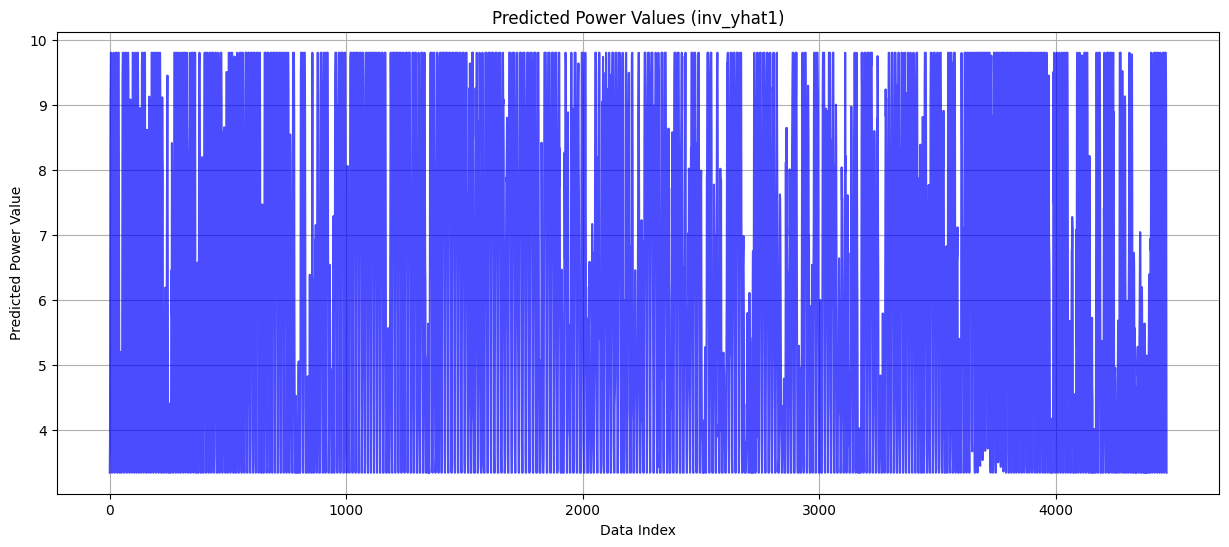

In [ ]:
import matplotlib.pyplot as plt

# 그래프 그리기
plt.figure(figsize=(15, 6))
plt.plot(inv_yhat1, color='blue', alpha=0.7)
plt.title('Predicted Power Values (inv_yhat1)')
plt.xlabel('Data Index')
plt.ylabel('Predicted Power Value')
plt.grid(True)
plt.show()


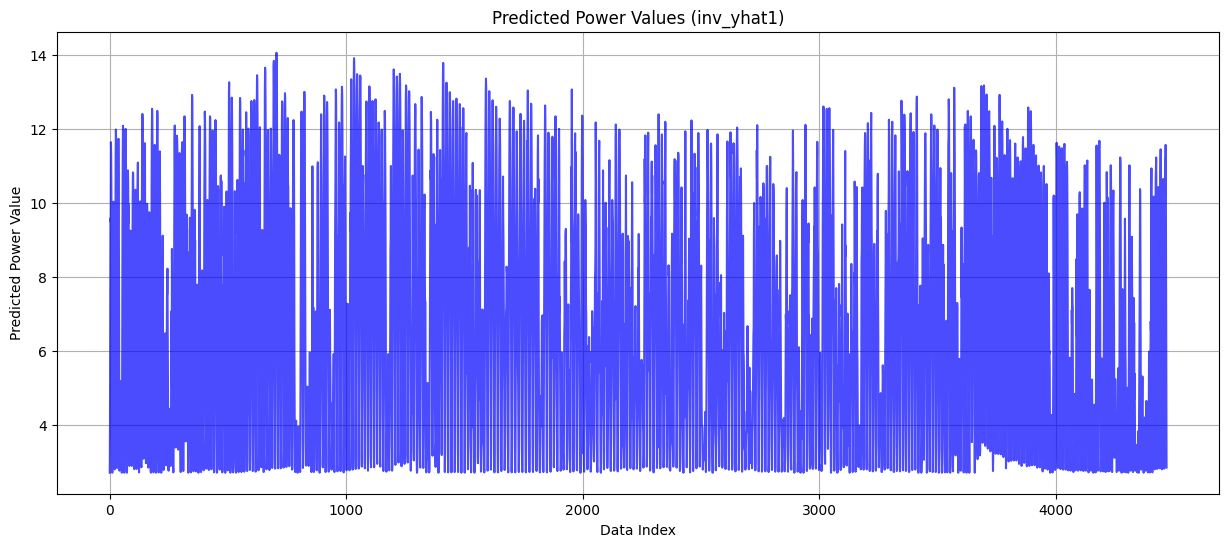

In [ ]:
import matplotlib.pyplot as plt

# 그래프 그리기
plt.figure(figsize=(15, 6))
plt.plot(inv_y1, color='blue', alpha=0.7)
plt.title('Predicted Power Values (inv_yhat1)')
plt.xlabel('Data Index')
plt.ylabel('Predicted Power Value')
plt.grid(True)
plt.show()


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def apply_standard_scaling(train_file_path, test_file_path):
    # Load the datasets
    train_data = pd.read_csv(train_file_path).drop(columns=['time'])
    test_data = pd.read_csv(test_file_path).drop(columns=['time'])

    # Initialize the scaler
    scaler = StandardScaler().fit(train_data)

    # Transform the datasets
    train_data_scaled = pd.DataFrame(scaler.transform(train_data), columns=train_data.columns)
    test_data_scaled = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)
    return train_data_scaled, test_data_scaled

def get_data_splits(dataframe):
    X = dataframe.drop(columns=['power'])
    y = dataframe['power']
    return X, y

def create_and_train_model(train_X, train_y, n_neurons, n_batch_size, dropout, additional_layer):
    # Splitting the data into training and validation sets
    train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.2, shuffle=False)

    model = Sequential()
    model.add(GRU(units=n_neurons, return_sequences=True, input_shape=(1, train_X.shape[1])))
    model.add(Dropout(dropout))

    if additional_layer:
        model.add(GRU(units=n_neurons, return_sequences=True))
        model.add(Dropout(dropout))

    model.add(GRU(units=n_neurons, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(units=n_neurons, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError()])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    mc = ModelCheckpoint(f_name, monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    rl = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00000001)

    train_X2 = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
    valid_X2 = valid_X.values.reshape((valid_X.shape[0], 1, valid_X.shape[1]))

    model.fit(train_X2, train_y, validation_data=(valid_X2, valid_y), epochs=100, verbose=1, batch_size=n_batch_size, callbacks=[es, mc, rl], shuffle=False)

    return model


def main():
    train_scaled_df, test_scaled_df = apply_standard_scaling('era5_train_set.csv', 'era5_test_set.csv')

    train_X, train_y = get_data_splits(train_scaled_df)
    test_X, test_y = get_data_splits(test_scaled_df)

    model = create_and_train_model(train_X, train_y, n_neurons, n_batch_size, dropout, additional_layer)

    train_accuracy = model.evaluate(train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1])), train_y.values, verbose=1)
    test_accuracy = model.evaluate(test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1])), test_y.values, verbose=1)

    return train_accuracy, test_accuracy

if __name__ == "__main__":
    additional_layer = True
    n_neurons = 64
    n_batch_size = 32
    combination_no = 9
    dropout = 0.2

    f_name = f'era5_best_model_linear{combination_no}.h5'
    train_accuracy, test_accuracy = main()
    print(f"Train accuracy: {train_accuracy}")
    print(f"Test accuracy: {test_accuracy}")

# loss, acc
# Train accuracy: [0.050078004598617554, 0.22378115355968475]
# Test accuracy: [0.07076387852430344, 0.26601481437683105]


Epoch 1/100
981/981 [==============================] - 19s 8ms/step - loss: 0.6459 - root_mean_squared_error: 0.8037 - val_loss: 0.4711 - val_root_mean_squared_error: 0.6864 - lr: 0.0010
Epoch 2/100
981/981 [==============================] - 7s 7ms/step - loss: 0.4420 - root_mean_squared_error: 0.6648 - val_loss: 0.3958 - val_root_mean_squared_error: 0.6291 - lr: 0.0010
Epoch 3/100
981/981 [==============================] - 7s 7ms/step - loss: 0.4106 - root_mean_squared_error: 0.6408 - val_loss: 0.3678 - val_root_mean_squared_error: 0.6064 - lr: 0.0010
Epoch 4/100
981/981 [==============================] - 7s 7ms/step - loss: 0.3930 - root_mean_squared_error: 0.6269 - val_loss: 0.3456 - val_root_mean_squared_error: 0.5879 - lr: 0.0010
Epoch 5/100
981/981 [==============================] - 8s 8ms/step - loss: 0.3801 - root_mean_squared_error: 0.6165 - val_loss: 0.3398 - val_root_mean_squared_error: 0.5829 - lr: 0.0010
Epoch 6/100
981/981 [==============================] - 8s 8ms/step - 

In [4]:
# 원래 train 데이터의 'power' 열의 표준 편차를 구합니다.
original_train_data = pd.read_csv('era5_train_set.csv')
std_dev_power = original_train_data['power'].std()

# RMSE를 표준 편차로 나누어 "normalized RMSE"를 구합니다.
normalized_rmse_train = train_accuracy[1] / std_dev_power
normalized_rmse_test = test_accuracy[1] / std_dev_power

print(f"Normalized RMSE (Train): {normalized_rmse_train}")
print(f"Normalized RMSE (Test): {normalized_rmse_test}")
#Normalized RMSE (Train): 6.637787843858323e-08
# Normalized RMSE (Test): 7.890521042853653e-08

Normalized RMSE (Train): 1.5014424276651199e-07
Normalized RMSE (Test): 1.5270733710136692e-07


140/140 [==============================] - 1s 2ms/step


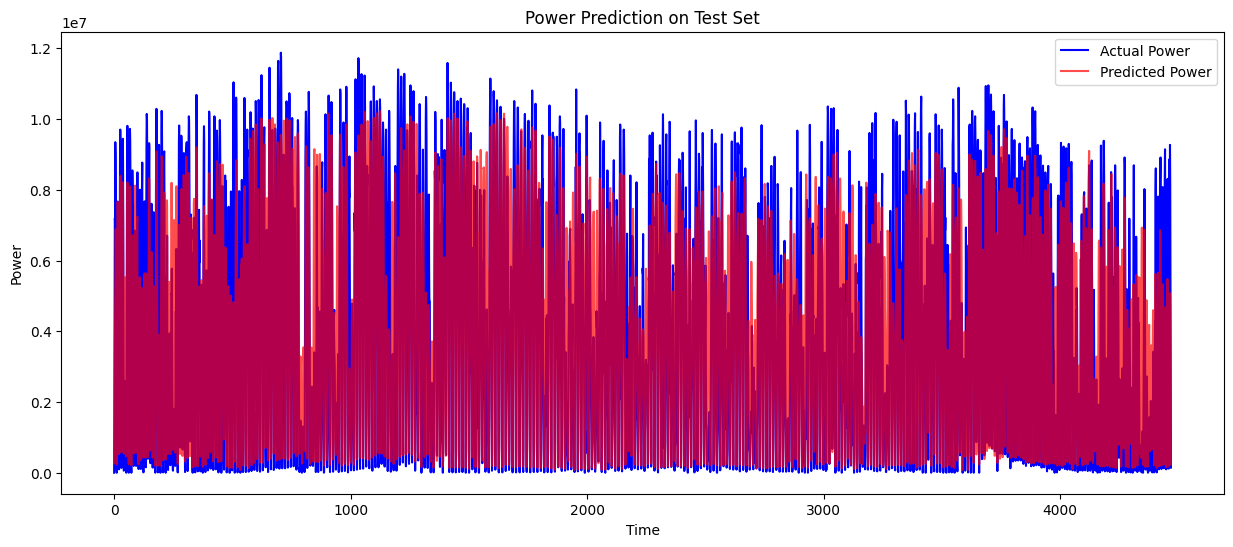

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

# 1. 모델 로드
model = load_model('era5_best_model_linear9.h5')

# 2. 데이터 로드 및 스케일링
train_data = pd.read_csv('era5_train_set.csv')
test_data = pd.read_csv('era5_test_set.csv')

# 'DateTime' 열을 삭제
train_data_no_time = train_data.drop(columns=['time'])
test_data_no_time = test_data.drop(columns=['time'])

# 스케일러 초기화 및 학습 데이터로 학습
scaler = StandardScaler()
scaler.fit(train_data_no_time.values.astype('float32'))

# test 데이터 스케일링
test_scaled_array = scaler.transform(test_data_no_time.values.astype('float32'))
test_scaled_df = pd.DataFrame(test_scaled_array, columns=test_data_no_time.columns)

# 3. test set에서 예측 수행
test_X = test_scaled_df.drop(columns=['power'])
test_X2 = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))

yhat = model.predict(test_X2)

# 스케일 되기 전 원래의 값의 형태로 예측 값 변환
power_mean = scaler.mean_[-1]
power_std = np.sqrt(scaler.var_[-1])

inv_yhat = yhat * power_std + power_mean

# 실제 값을 스케일 되기 전 원래의 값의 형태로 변환
inv_y = test_data_no_time['power'].values

# 4. 원래의 스케일로 변환된 예측 값과 실제 값을 플롯에 나타냅니다.
plt.figure(figsize=(15, 6))
plt.plot(inv_y, label='Actual Power', color='blue')
plt.plot(inv_yhat, label='Predicted Power', color='red', alpha=0.7)
plt.title('Power Prediction on Test Set')
plt.xlabel('Time')
plt.ylabel('Power')
plt.legend()
plt.show()


In [ ]:
inv_yhat.shape

(4470, 1)

In [ ]:
inv_y.shape

(4470,)

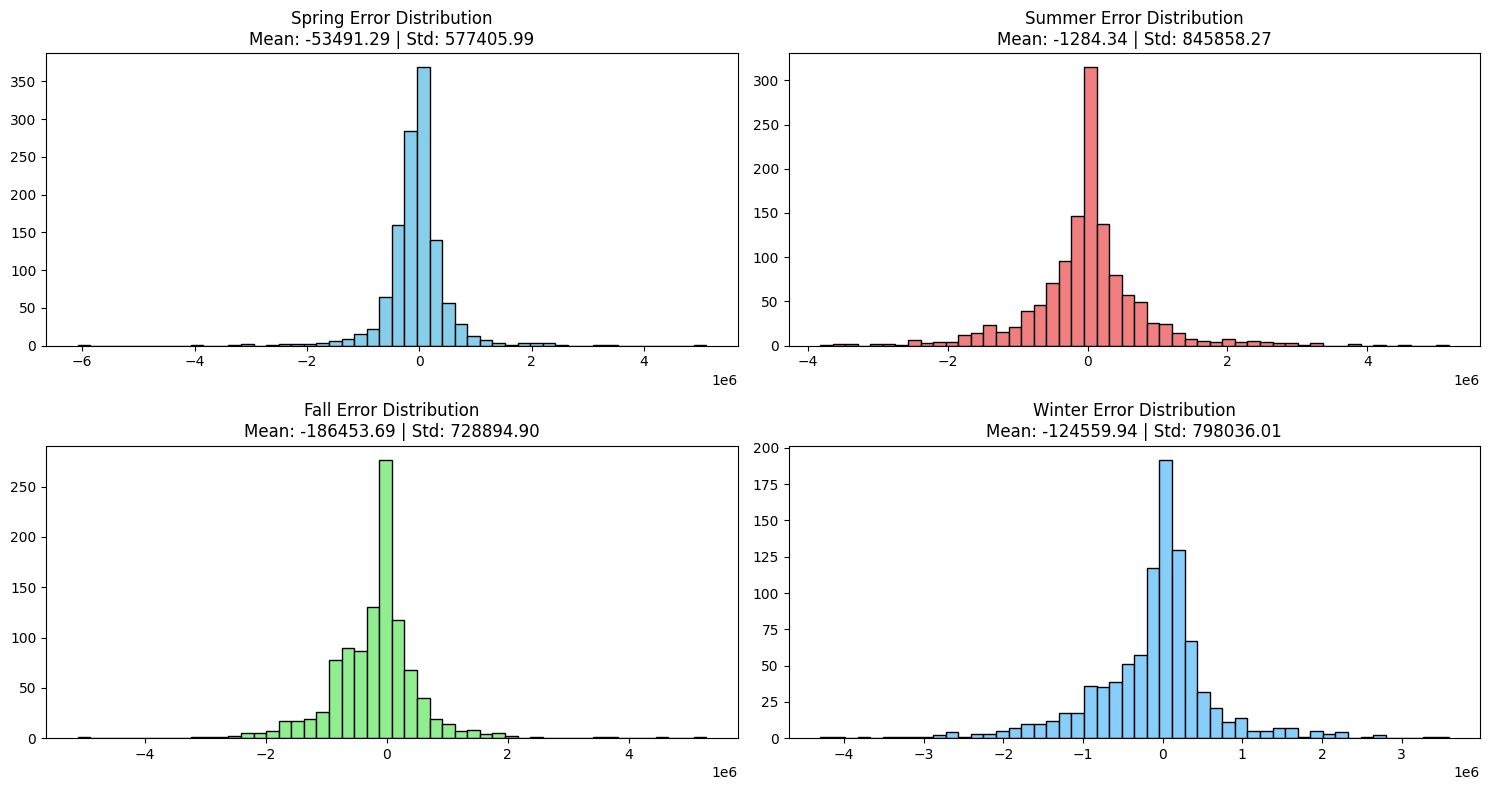

In [ ]:
# 오차(실제값 - 예측값) 계산
inv_yhat_flat = inv_yhat.flatten()
error = inv_y - inv_yhat_flat

# test_data에서 'Month' 칼럼 추출
months = test_data['Month'].values

# 계절별로 오차를 나눕니다.
spring_error = error[np.isin(months, [3, 4, 5])]
summer_error = error[np.isin(months, [6, 7, 8])]
fall_error = error[np.isin(months, [9, 10, 11])]
winter_error = error[np.isin(months, [12, 1, 2])]

# 계절별 오차의 평균과 표준편차 계산
spring_mean, spring_std = np.mean(spring_error), np.std(spring_error)
summer_mean, summer_std = np.mean(summer_error), np.std(summer_error)
fall_mean, fall_std = np.mean(fall_error), np.std(fall_error)
winter_mean, winter_std = np.mean(winter_error), np.std(winter_error)

# 계절별 오차를 시각화합니다.
plt.figure(figsize=(15, 8))

# 봄
plt.subplot(2, 2, 1)
plt.hist(spring_error, bins=50, color='skyblue', edgecolor='black')
plt.title(f'Spring Error Distribution\nMean: {spring_mean:.2f} | Std: {spring_std:.2f}')

# 여름
plt.subplot(2, 2, 2)
plt.hist(summer_error, bins=50, color='lightcoral', edgecolor='black')
plt.title(f'Summer Error Distribution\nMean: {summer_mean:.2f} | Std: {summer_std:.2f}')

# 가을
plt.subplot(2, 2, 3)
plt.hist(fall_error, bins=50, color='lightgreen', edgecolor='black')
plt.title(f'Fall Error Distribution\nMean: {fall_mean:.2f} | Std: {fall_std:.2f}')

# 겨울
plt.subplot(2, 2, 4)
plt.hist(winter_error, bins=50, color='lightskyblue', edgecolor='black')
plt.title(f'Winter Error Distribution\nMean: {winter_mean:.2f} | Std: {winter_std:.2f}')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


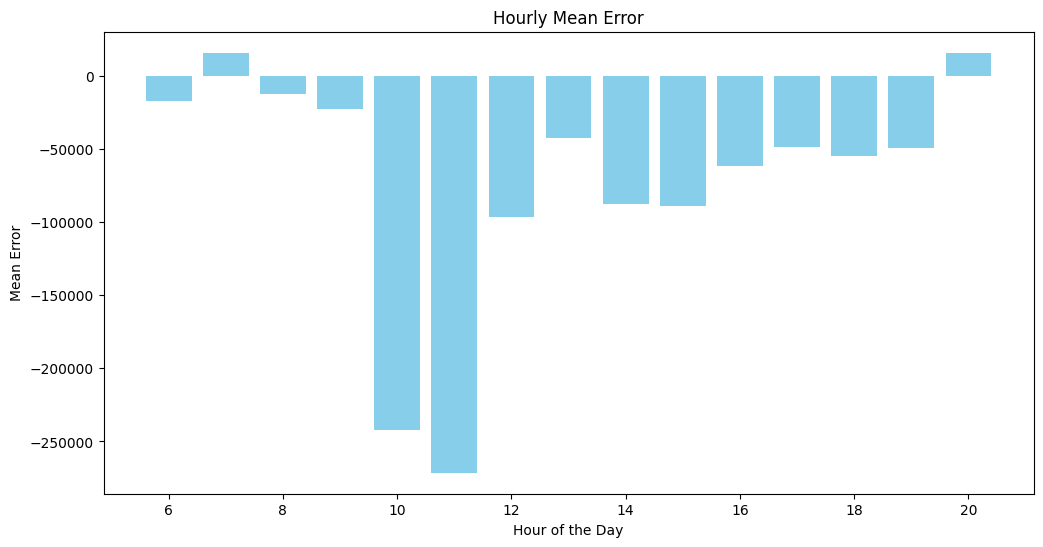

In [ ]:
# test_data에서 'Hour' 칼럼 추출
hours = test_data['Hour'].values

# 시간대별로 오차를 나눕니다.
hourly_errors = {hour: error[hours == hour] for hour in range(24)}

# 시간대별 오차의 평균 계산
hourly_mean_errors = {hour: np.mean(errors) for hour, errors in hourly_errors.items()}

# 시간대별 오차를 시각화합니다.
plt.figure(figsize=(12, 6))
plt.bar(hourly_mean_errors.keys(), hourly_mean_errors.values(), color='skyblue')
plt.title('Hourly Mean Error')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Error')
plt.show()


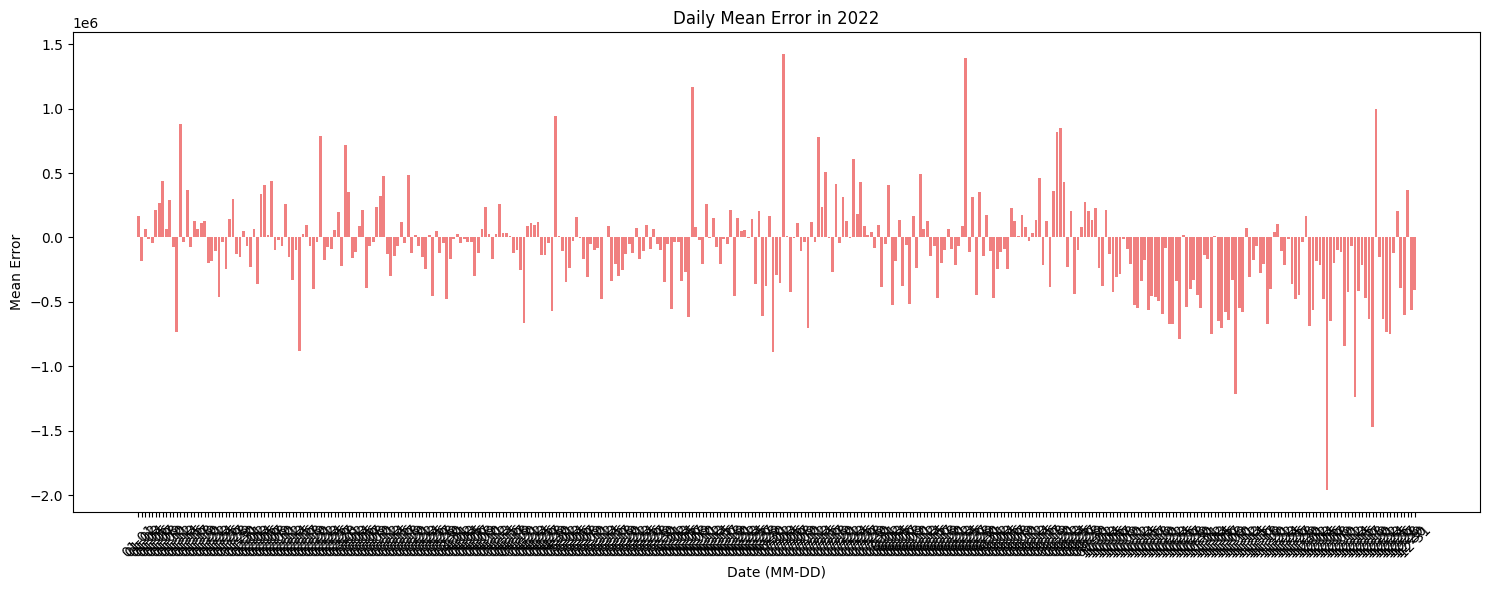

In [ ]:
# test_data에서 'Day'와 'Month' 칼럼 추출
days = test_data['Day'].values
months = test_data['Month'].values

# 월-일 형식의 문자열로 변환
date_strings = [f"{month:02d}-{day:02d}" for month, day in zip(months, days)]

# 각 일자별로 오차를 나눕니다.
daily_errors = {}
for date_str, err in zip(date_strings, error):
    if date_str not in daily_errors:
        daily_errors[date_str] = []
    daily_errors[date_str].append(err)

# 일자별 오차의 평균 계산
daily_mean_errors = {date: np.mean(errors) for date, errors in daily_errors.items()}

# 일자별 오차를 시각화합니다.
plt.figure(figsize=(15, 6))
plt.bar(daily_mean_errors.keys(), daily_mean_errors.values(), color='lightcoral')
plt.title('Daily Mean Error in 2022')
plt.xlabel('Date (MM-DD)')
plt.ylabel('Mean Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


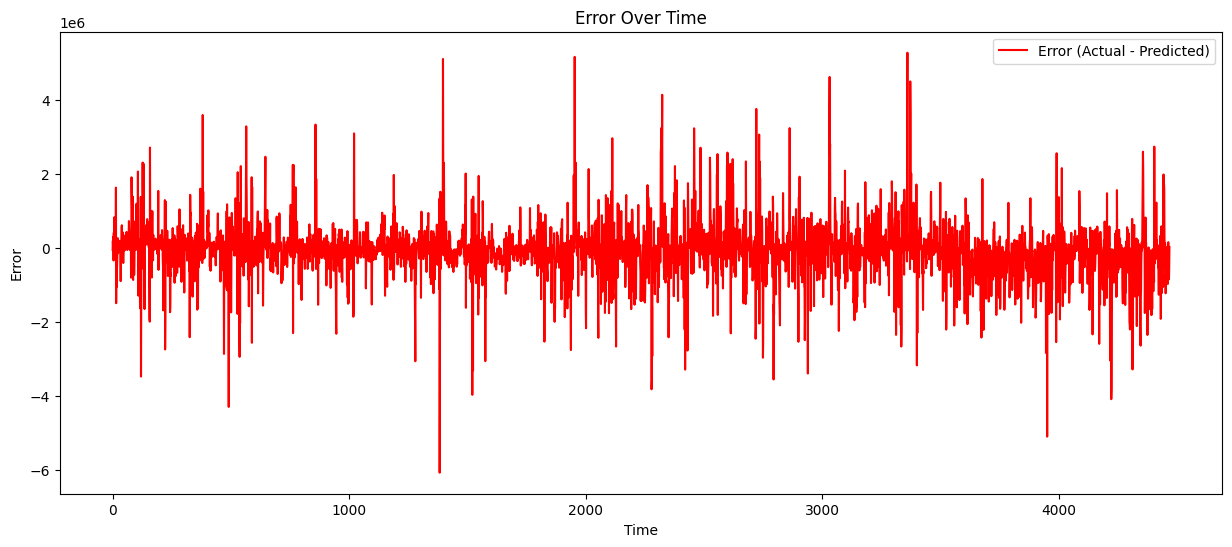

In [ ]:
inv_yhat_flat = inv_yhat.flatten()
error = inv_y - inv_yhat_flat

plt.figure(figsize=(15, 6))
plt.plot(error, label='Error (Actual - Predicted)', color='red')
plt.title('Error Over Time')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.show()

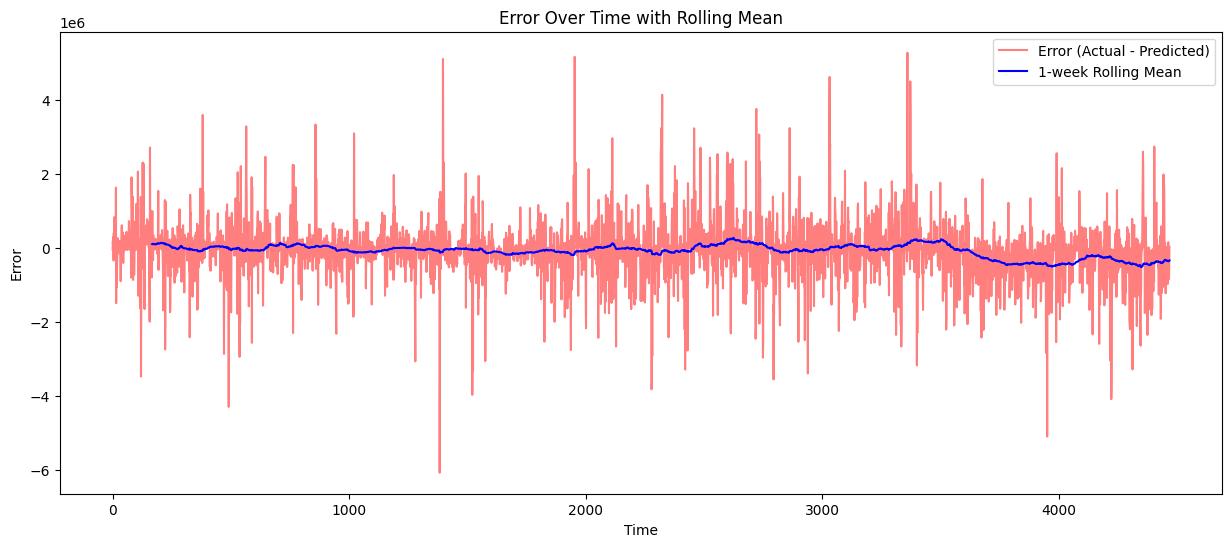

In [ ]:
# 이동 평균 계산
rolling_mean = pd.Series(error).rolling(window=24*7).mean()  # 1주일의 이동평균

plt.figure(figsize=(15, 6))
plt.plot(error, label='Error (Actual - Predicted)', color='red', alpha=0.5)
plt.plot(rolling_mean, label='1-week Rolling Mean', color='blue')
plt.title('Error Over Time with Rolling Mean')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.show()


             Month          Day         Hour  Temperature(C)  \
count  1341.000000  1341.000000  1341.000000     1341.000000   
mean      7.220731    15.595078    13.170768       17.555481   
std       3.311971     8.874882     2.441539        9.886291   
min       1.000000     1.000000     7.000000       -3.600000   
25%       5.000000     8.000000    11.000000        9.400000   
50%       7.000000    16.000000    13.000000       19.300000   
75%      10.000000    23.000000    15.000000       26.400000   
max      12.000000    31.000000    19.000000       33.200000   

       Precipitation(mm)  Humidity(%)  VaporPressure(hPa)  \
count        1341.000000  1341.000000         1341.000000   
mean           -0.928039    64.339299           15.545936   
std             0.400863    14.516502            9.730327   
min            -1.000000    25.000000            2.300000   
25%            -1.000000    54.000000            6.500000   
50%            -1.000000    65.000000           13.300000

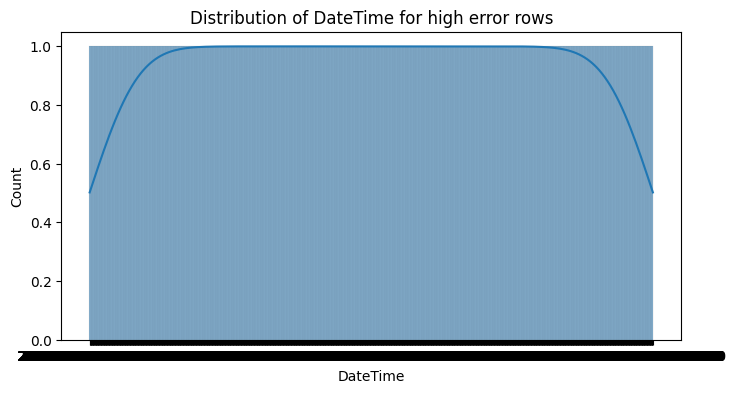

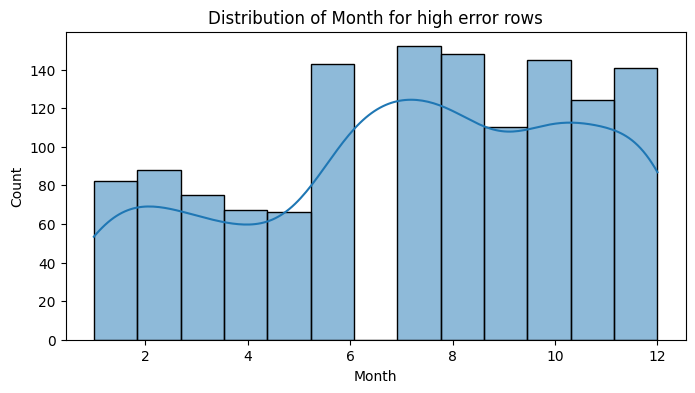

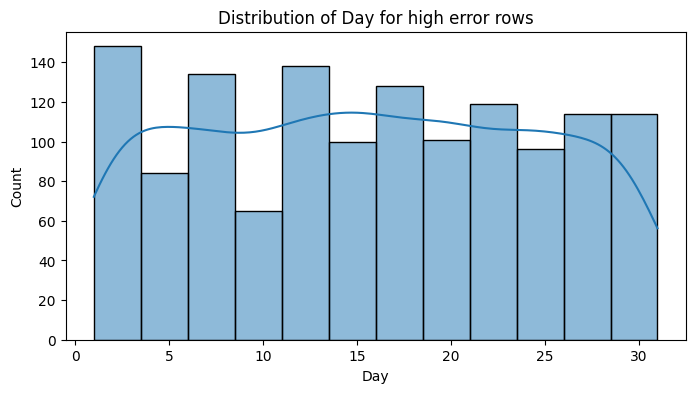

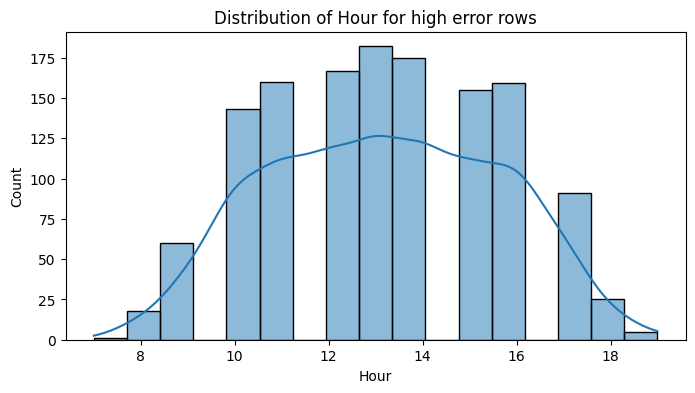

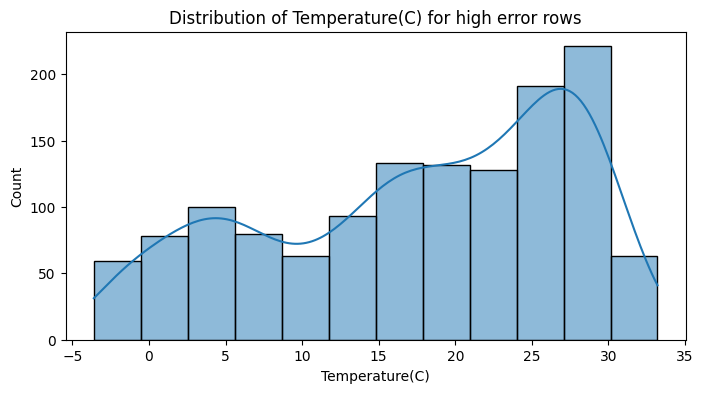

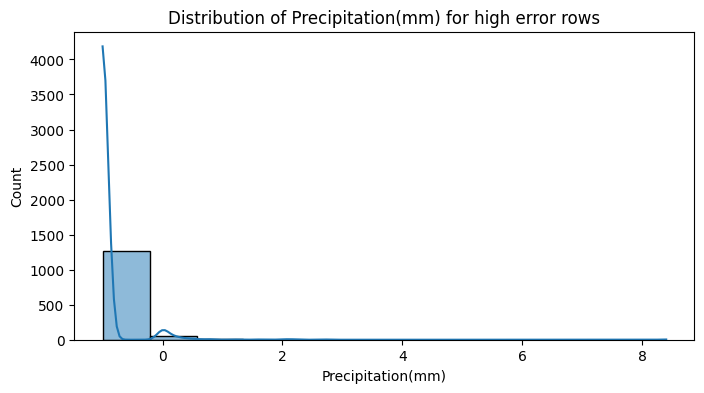

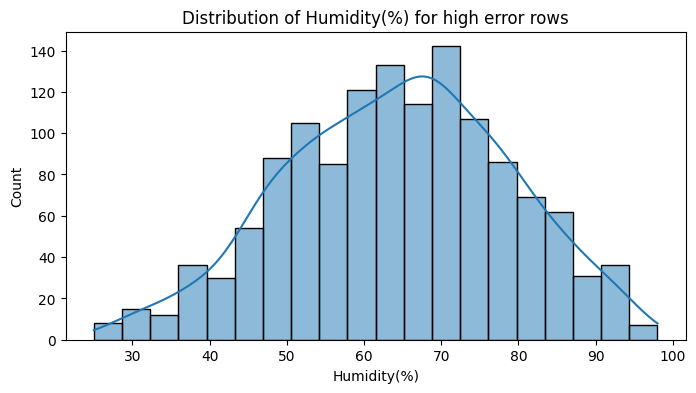

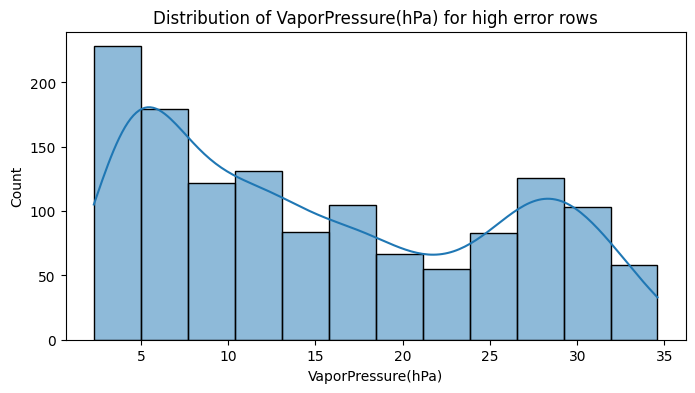

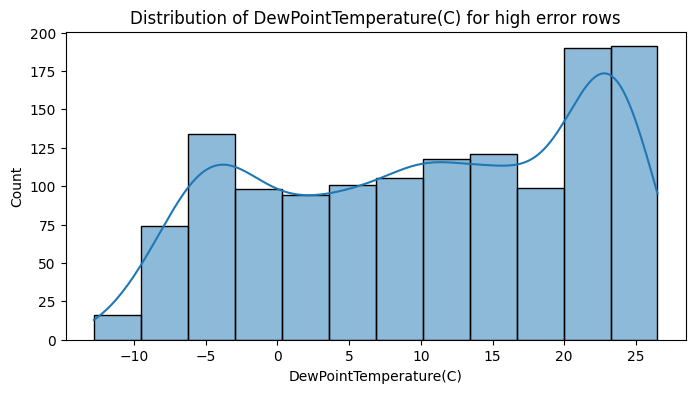

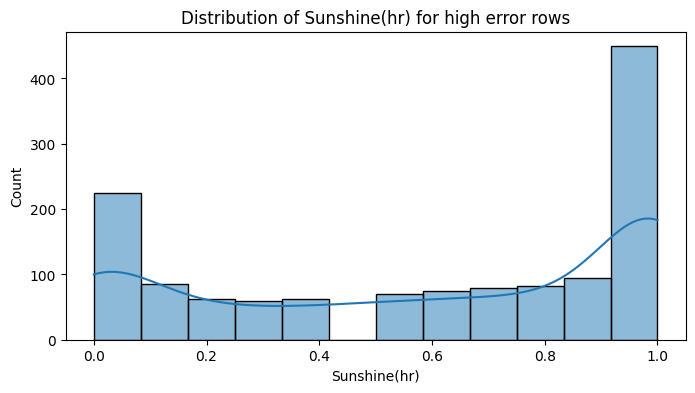

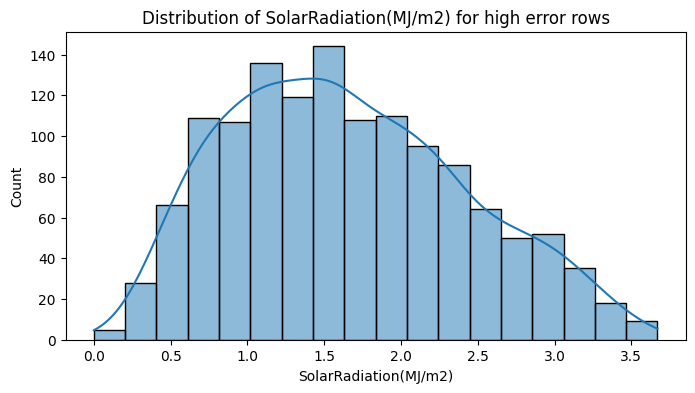

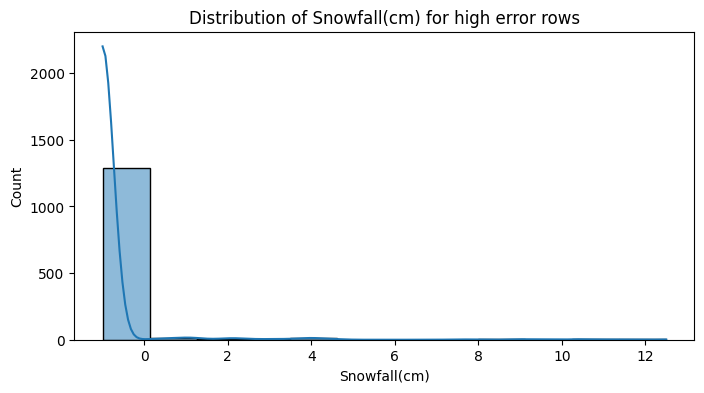

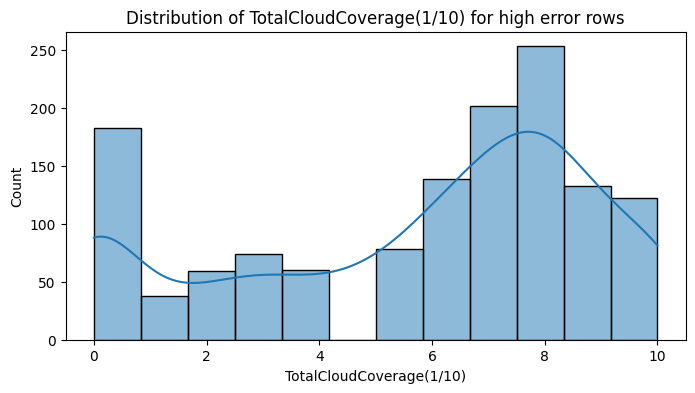

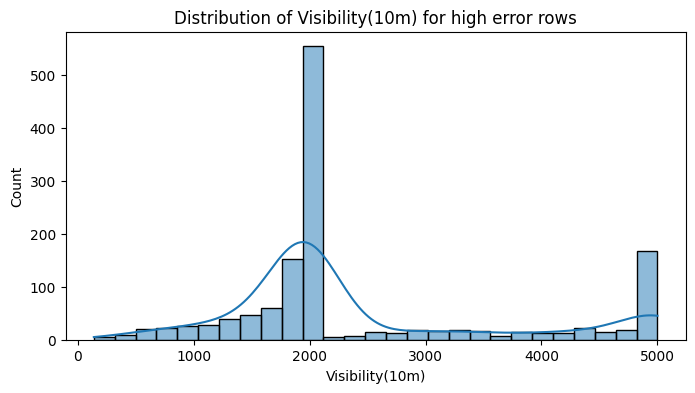

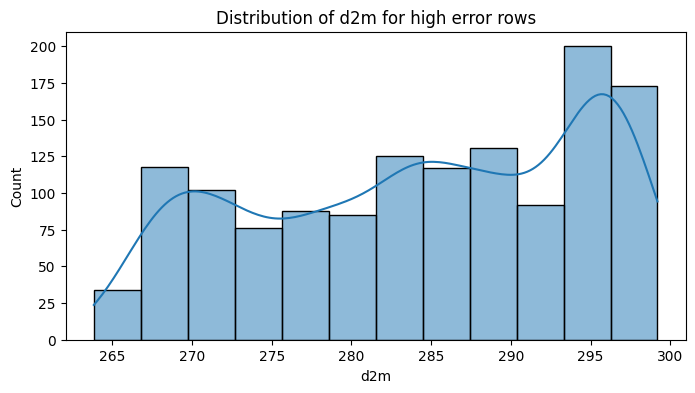

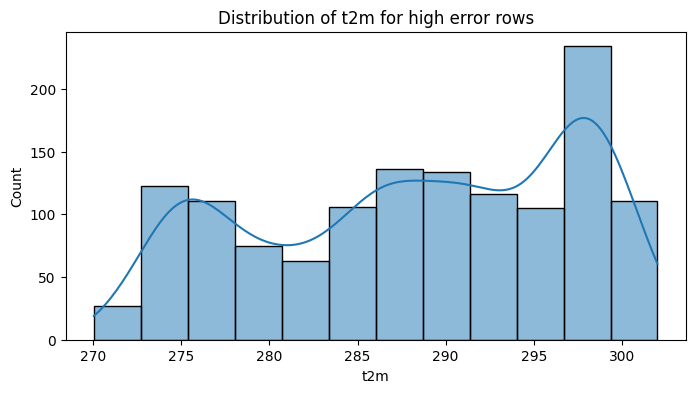

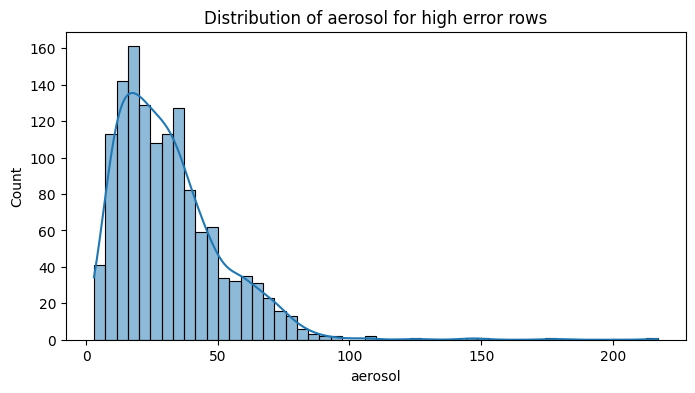

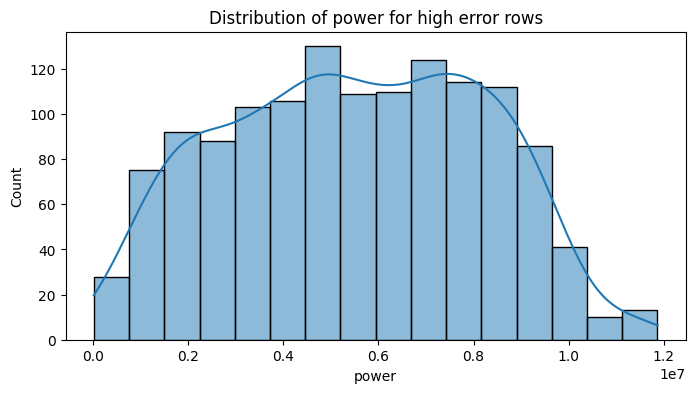

In [ ]:
# 1. 오차의 절대값을 기준으로 상위 30%의 행을 선택
threshold = np.percentile(np.abs(error), 70) # 상위 30%의 오차 값
high_error_indices = np.where(np.abs(error) >= threshold)[0]

# 2. 이러한 행들에서 각 특성의 분포를 살펴보기 위한 기초 통계량 및 시각화
high_error_data = test_data.iloc[high_error_indices]

# 기초 통계량 출력
print(high_error_data.describe())

# 각 특성의 분포 시각화
for column in high_error_data.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(high_error_data[column], kde=True)
    plt.title(f'Distribution of {column} for high error rows')
    plt.show()


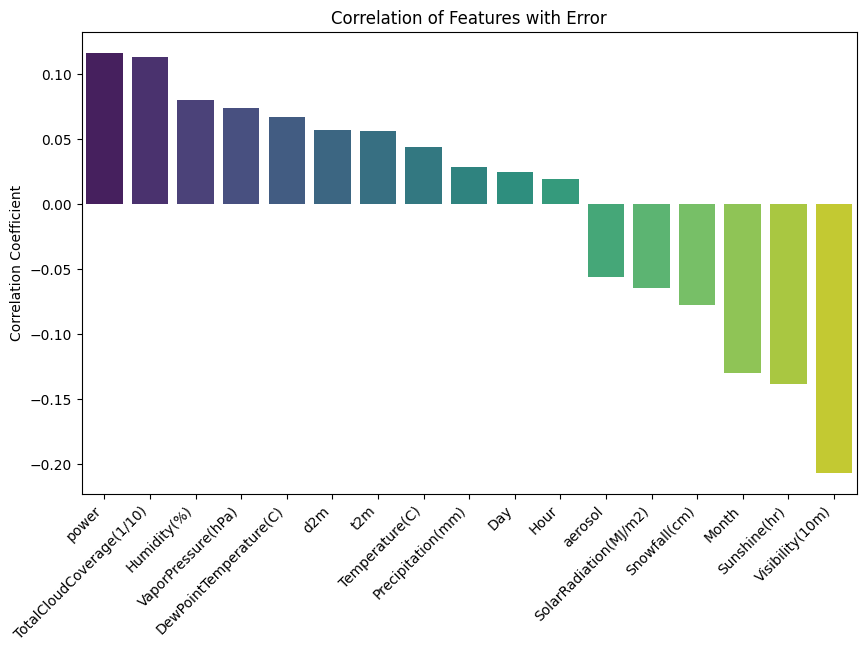

In [ ]:
# 3. 전체 데이터셋에 대한 각 특성과 오차 간의 상관 계수를 계산
correlations = {}
for column in test_data.columns:
    if column != 'DateTime':  # DateTime은 숫자가 아니므로 제외
        correlation = np.corrcoef(test_data[column], error)[0, 1]
        correlations[column] = correlation

# 4. 상관 계수를 시각화
sorted_columns = sorted(correlations, key=correlations.get, reverse=True)
sorted_correlations = [correlations[col] for col in sorted_columns]

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_columns, y=sorted_correlations, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title('Correlation of Features with Error')
plt.ylabel('Correlation Coefficient')
plt.show()
